# РГР 1


## 1. Подготовка данных

### Датасет
- `x=hours_studied`
- `y=exame_score`


По оси $Ox$ представлены часы подготовки к экзамену, по оси $Oy$ - результаты экзамена

In [58]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, pearsonr, shapiro, normaltest
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings('ignore')

path = kagglehub.dataset_download("grandmaster07/student-exam-score-dataset-analysis")
print("Path to dataset files:", path)

df = pd.read_csv("/Users/danyarmarkin/.cache/kagglehub/datasets/grandmaster07/student-exam-score-dataset-analysis/versions/1/student_exam_scores.csv")

Path to dataset files: /Users/danyarmarkin/.cache/kagglehub/datasets/grandmaster07/student-exam-score-dataset-analysis/versions/1


In [3]:
# Просмотр структуры данных
print("Размер данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nОписательная статистика:")
print(df.describe())

Размер данных: (200, 6)

Первые 5 строк:
  student_id  hours_studied  sleep_hours  attendance_percent  previous_scores  \
0       S001            8.0          8.8                72.1               45   
1       S002            1.3          8.6                60.7               55   
2       S003            4.0          8.2                73.7               86   
3       S004            3.5          4.8                95.1               66   
4       S005            9.1          6.4                89.8               71   

   exam_score  
0        30.2  
1        25.0  
2        35.8  
3        34.0  
4        40.3  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   

In [114]:
x = df["hours_studied"]
y = df["exam_score"]

def thin_to_normal(x, y, target_size=None):
    if target_size is None:
        target_size = int(len(x) * 0.42)
    target_mean = np.mean(x)
    target_std = np.std(x)
    normal_pdf = norm.pdf(x, loc=target_mean, scale=target_std)
    probabilities = normal_pdf / np.sum(normal_pdf)
    selected_indices = np.random.choice(
        len(x),
        size=target_size,
        replace=False,
        p=probabilities
    )

    return x.iloc[selected_indices], y.iloc[selected_indices]

x, y = thin_to_normal(x, y)

n = len(x)

print(f"Размер набора данных: {n}")

Размер набора данных: 84


## 2. Построение и анализ корреляционного поля

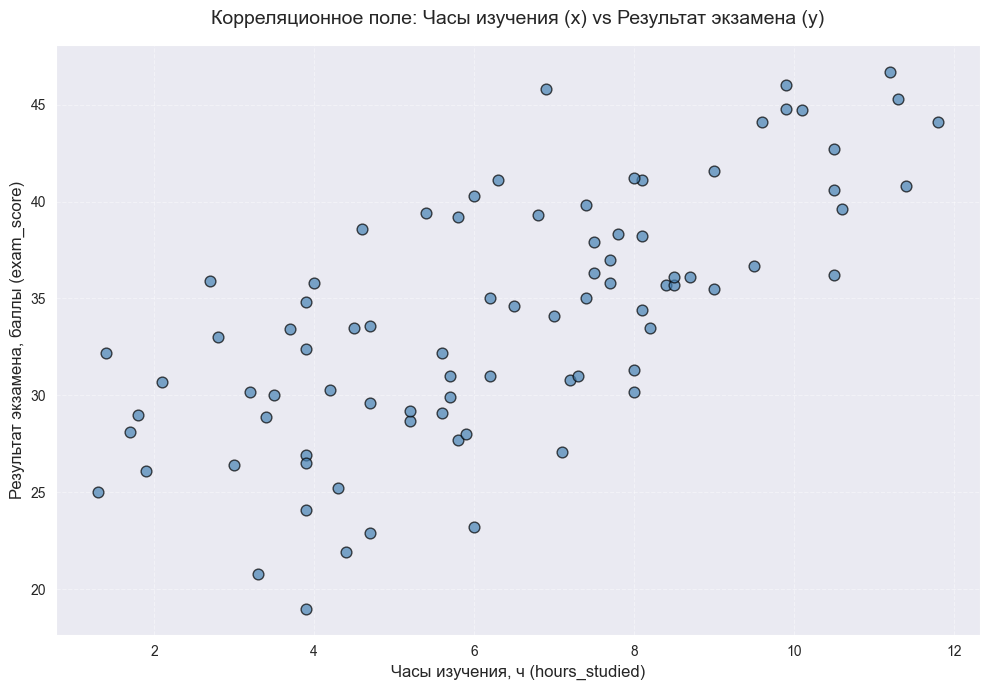

In [74]:
plt.figure(figsize=(10, 7))
plt.scatter(x, y, alpha=0.7, color='steelblue', edgecolors='k', s=60)
plt.title('Корреляционное поле: Часы изучения (x) vs Результат экзамена (y)', fontsize=14, pad=15)
plt.xlabel('Часы изучения, ч (hours_studied)', fontsize=12)
plt.ylabel('Результат экзамена, баллы (exam_score)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Вывод
Исходя из графика выдвигаем гипотезу о том, что существует линейная зависимость между `x` и `y`

## 3. Анализ связи между переменными

### Тест Шапиро-Уилки

Проверка гипотезы о нормальности распределения данных.

$H_0$:
    Распределение данных НЕ ОТЛИЧАЕТСЯ от нормального

$H_1$:
    Распределение НЕ нормальное.

$W=\dfrac{1}{\frac{1}{n}\sum_{i=1}^nx_i}\left(\sum_{i=1}^na_{n-i+1}(x_{n-i+1}-x_i)\right)^2$

Если $W>W(\alpha)$, то $H_0$ не отвергается

In [76]:
def test_normality(data, name):
    print(f"\nТесты на нормальность для {name}:")
    shapiro_stat, shapiro_p = shapiro(data)
    print(f"Shapiro-Wilk: статистика = {shapiro_stat:.4f}, p-value = {shapiro_p:.4e}")
    alpha = 0.05
    if shapiro_p > alpha:
        print("Гипотеза о нормальности не отвергается")
    else:
        print("Гипотеза о нормальности отвергается")

test_normality(x, "x (hours_studied)")

test_normality(y, "y (exam_score)")


Тесты на нормальность для x (hours_studied):
Shapiro-Wilk: статистика = 0.9789, p-value = 1.8476e-01
Гипотеза о нормальности не отвергается

Тесты на нормальность для y (exam_score):
Shapiro-Wilk: статистика = 0.9881, p-value = 6.3914e-01
Гипотеза о нормальности не отвергается


### Коэффициент корреляции Пирсона

$r=\dfrac{\frac{1}{n} \sum(y_i-\overline{y})(x_i-\overline{x})}{\sqrt{\frac{1}{n} \sum(y_i-\overline{y})^2}\sqrt{\frac{1}{n} \sum(x_i-\overline{x})^2}}$

### Критерий Стьюдента

$t=\dfrac{|r|\sqrt{n-2}}{\sqrt{1-r^2}}$

$t_c(\alpha, n-2)$

$H_0$: Связь статистически незначима

$H_1$: Связь статистически значима

Если $|t| < |t_c|$, то $H_0$ не отвергается

In [111]:
# Коэффициент корреляции Пирсона
r, p_value = pearsonr(x, y)

print(f"Коэффициент корреляции Пирсона:")
print(f"r = {r:.4f}")
print(f"p-value = {p_value:.4e}")

alpha = 0.05
if p_value < alpha:
    print(f"Связь статистически значима")
else:
    print(f"Связь статистически НЕ значима")

Коэффициент корреляции Пирсона:
r = 0.7016
p-value = 1.0601e-13
Связь статистически значима


### Доверительный интервал при помощи Z-преобразования Фишера

$th(arth(r)-\frac{U_\gamma}{n-3}) < r < th(arth(r)+\frac{U_\gamma}{n-3})$

$U_\gamma$ - квантиль стандартного нормального распределения для уровня $1-\frac{\alpha}{2}$

In [82]:
z_r = np.arctanh(r)  # Fisher z-transform
se_z = stats.norm.ppf(0.975) / np.sqrt(n - 3)

ci_z_lower = z_r - se_z
ci_z_upper = z_r + se_z

ci_r_lower = np.tanh(ci_z_lower)
ci_r_upper = np.tanh(ci_z_upper)

print(f"95% доверительный интервал для r:")
print(f"[{ci_r_lower:.4f}; {ci_r_upper:.4f}]")

95% доверительный интервал для r:
[0.5734; 0.7962]


### Вывод
Таким образом получаем вероятно линейную зависимость `y` от `x`, коэффициент корреляции статистически значим (доверительный интервал [0.5734; 0.7962])

## 4. Оценка коэффициентов модели линейной регрессии

### Уравнение регрессии

**Коэффициенты регрессии**
$\Theta = (X^TX)^{-1}X^TY$

**Коэффициент детерминации**
$R^2=1-\dfrac{\sum(y_i-\tilde{y_i})^2}{\sum(y_i-\overline{y})^2}$

In [81]:

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
beta_0 = model.params[0]
beta_1 = model.params[1]

print(f"Уравнение регрессии:")
print(f"y = {beta_0:.4f} + {beta_1:.4f} * x")

print(model.summary())

Уравнение регрессии:
y = 23.2454 + 1.6937 * x
                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     79.49
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           1.06e-13
Time:                        01:23:17   Log-Likelihood:                -246.35
No. Observations:                  84   AIC:                             496.7
Df Residuals:                      82   BIC:                             501.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------


### F-тест, t-тест

**F-тест**

$H_0$ - модель статистически незначима

$H_1$ - модель статистически значима

$F=\dfrac{\frac{1}{m}\sum(\tilde{y_i}-\overline{y})^2}{\frac{1}{n-m-1}\sum(y_i-\tilde{y_i})^2}$

$F_c$ - квантиль распределения Фишера-Снедекора со степенями свободы $m$ и $n-m-1$, где m - количество факторов, т.е. 1 в нашем случае

Если $F>F_c$, то $H_0$ отвергается

**t-тест**

$H_0$ - коэффициент $\theta_0$ не значим

$H_1$ - коэффициент $\theta_0$ значим

$t=\dfrac{\tilde{\theta_i}}{S_{\theta_i}}$

Для $a$: $S_a=\dfrac{s\sqrt{\sum x^2_i}}{\sqrt{n\sum(x_i-\overline{x})^2}}$

Для $b$: $S_b=\dfrac{s}{\sqrt{n\sum(x_i-\overline{x})^2}}$

$s=\sqrt{\dfrac{\sum \varepsilon_i^2}{n-2}}$

$t_c(\alpha, n-2)$

Если $|t| < |t_c|$, то $H_0$ не отвергается

In [85]:
F_stat = model.fvalue
F_pvalue = model.f_pvalue

print(f"F-тест значимости уравнения регрессии:")
print(f"F = {F_stat:.4f}, p-value = {F_pvalue:.4e}")

t_beta0 = model.tvalues[0]
p_beta0 = model.pvalues[0]
t_beta1 = model.tvalues[1]
p_beta1 = model.pvalues[1]

print(f"\nt-тест для beta0")
print(f"t = {t_beta0:.4f}, p-value = {p_beta0:.4e}")

print(f"t-тест для beta1:")
print(f"t = {t_beta1:.4f}, p-value = {p_beta1:.4e}")

alpha = 0.05
if F_pvalue < alpha:
    print("Уравнение регрессии значимо в целом")
else:
    print("Уравнение НЕ значимо")

if p_beta0 < alpha:
    print("Коэффициент а значим")
else:
    print("Коэффициент а не значим")

if p_beta1 < alpha:
    print("Коэффициент b значим")
else:
    print("Коэффициент b не значим")

F-тест значимости уравнения регрессии:
F = 79.4853, p-value = 1.0601e-13

t-тест для beta0
t = 17.8006, p-value = 6.6849e-30
t-тест для beta1:
t = 8.9155, p-value = 1.0601e-13
Уравнение регрессии значимо в целом
Коэффициент а значим
Коэффициент b значим


### Средняя ошибка аппроксимации

$MAPE=\dfrac{1}{n}\sum\left|\dfrac{y_i-\tilde{y_i}}{y_i}\right|\cdot 100\%$

In [100]:
y_pred = model.predict(X)
mean_ape = np.mean(np.abs((y - y_pred) / y) * 100)

print(f"MAPE = {mean_ape:.2f}%")

MAPE = 11.02%


### Эластичность

$E = b \cdot \dfrac{\overline{x}}{\overline{y}}$

In [79]:
x_mean = x.mean()
y_mean = y.mean()
elasticity_mean = beta_1 * (x_mean / y_mean)

print(f"E = {elasticity_mean:.4f}")

E = 0.3044


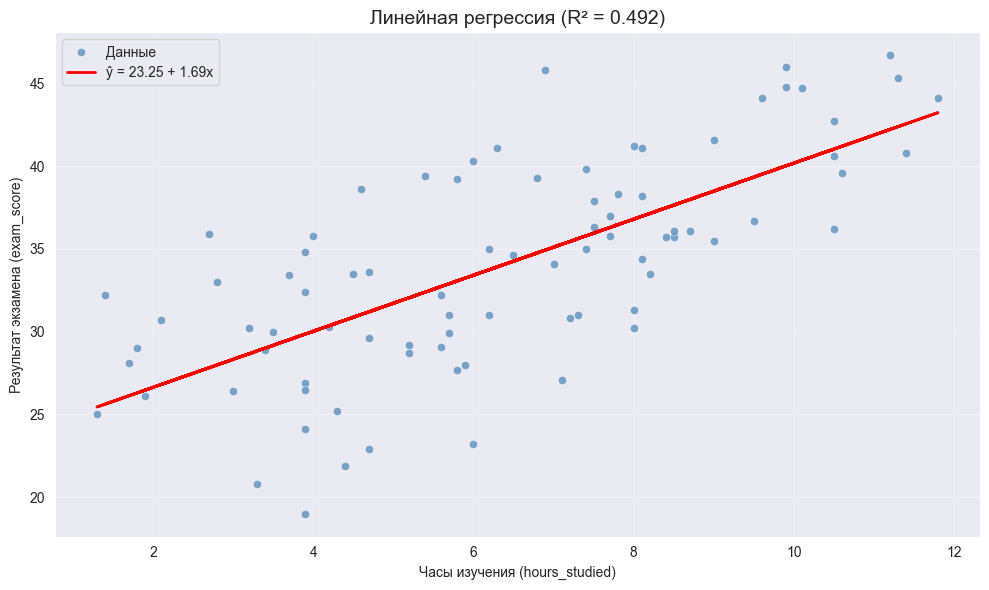

In [87]:
import seaborn as sns


R2 = model.rsquared
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, alpha=0.7, color='steelblue', label='Данные')
plt.plot(x, y_pred, color='red', linewidth=2, label=f'ŷ = {beta_0:.2f} + {beta_1:.2f}x')

plt.title(f'Линейная регрессия (R² = {R2:.3f})', fontsize=14)
plt.xlabel('Часы изучения (hours_studied)')
plt.ylabel('Результат экзамена (exam_score)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Анализ остатков

### Построим гистограмму остатков

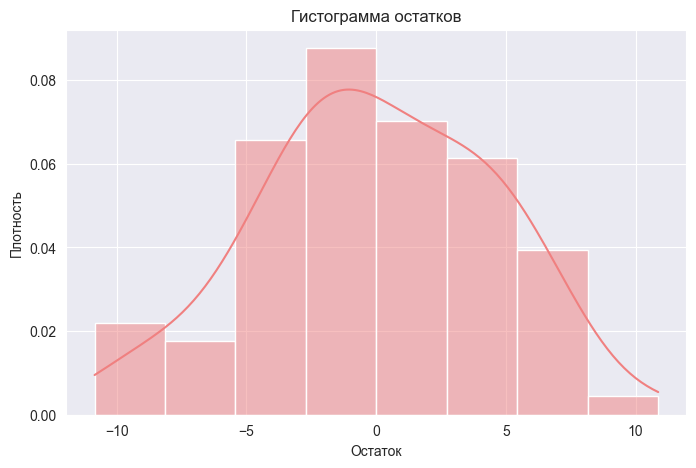

Тесты на нормальность остатков:
Shapiro-Wilk: W = 0.9908, p-value = 8.1952e-01
Нормальность остатков НЕ отвергается


In [89]:
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
residuals = model.resid

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, stat="density", color='lightcoral')
plt.title('Гистограмма остатков')
plt.xlabel('Остаток')
plt.ylabel('Плотность')
plt.show()


print("Тесты на нормальность остатков:")
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Shapiro-Wilk: W = {shapiro_stat:.4f}, p-value = {shapiro_p:.4e}")

alpha = 0.05
if shapiro_p > alpha:
    print("Нормальность остатков НЕ отвергается")
else:
    print("Нормальность остатков ОТВЕРГАЕТСЯ")

### Тест Дарбина-Уотсона

$H_0$ - отсутствие автокорреляции в данных

$H_1$ - присутствие автокорреляции в данных

$DW=2\left(1-\dfrac{\sum(\varepsilon_i-\varepsilon_{i-1})}{\sum\varepsilon_i^2}\right)$

Если $DW < d_1$ или $DW > 4- d_1$, то $H_0$ отвергается

Если $d_1 \leq DW < d2$ или $4 - d_2 < DW \leq 4 - d_1$, то нет достаточных оснований для принятия решений

Если $d_2 \leq DW \leq 4 - d_2$, то $H_0$ не отвергается

In [90]:
# Тест Дарбина-Уотсона
dw_stat = durbin_watson(residuals)

print(f"Тест Дарбина-Уотсона:")
print(f"DW = {dw_stat:.4f}")

if dw_stat < 1.5:
    print("Признаки положительной автокорреляции")
elif 1.5 <= dw_stat <= 2.5:
    print("Автокорреляция отсутствует")
else:
    print("Признаки отрицательной автокорреляции")

Тест Дарбина-Уотсона:
DW = 1.9112
Автокорреляция отсутствует


### Тест Голдфельда-Кванта



In [93]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

gq_stat, gq_pvalue, ordering = het_goldfeldquandt(residuals, x.values.reshape(-1, 1) )

print(f"Тест Голдфельда-Кванта:")
print(f"F-статистика = {gq_stat:.4f}")
print(f"p-value = {gq_pvalue:.4e}")

if gq_pvalue > 0.05:
    print("Гетероскедастичности нет")
else:
    print("Гетероскедастичность точно есть")

Тест Голдфельда-Кванта:
F-статистика = 1.3003
p-value = 2.0202e-01
Гетероскедастичности нет


### Условие Гаусса-Маркова
1. Сумма остатков 0
2. Нормальность остатков
3. Отсутствие автокорреляции
4. Отсутствие гетероскедастичности

In [98]:
conditions = {
    "Условие": [
        "Сумма остатков 0",
        "Нормальность остатков",
        "Отсутствие автокорреляции",
        "Отсутствие гетероскедастичности"
    ],
    "Результат": [
        f"sum(eps) = {sum(model.resid) :0.5f} -> T",
        f"p_SW = {shapiro_p:.2e} -> {'T' if shapiro_p > 0.05 else 'F'}",
        f"DW = {dw_stat:.3f} -> {'T' if 1.5 <= dw_stat <= 2.5 else 'F'}",
        f"p = {gq_pvalue:.2e} -> {'T' if gq_pvalue > 0.05 else 'F'}"
    ]
}
pd.DataFrame(conditions)

,Условие,Результат
0,Сумма остатков 0,sum(eps) = 0.00000 -> T
1,Нормальность остатков,p_SW = 8.20e-01 -> T
2,Отсутствие автокорреляции,DW = 1.911 -> T
3,Отсутствие гетероскедастичности,p = 2.02e-01 -> T


## 6. Построение альтернативных моделей
1. Логарифмическая (апочемубынет)
2. Квадратическая

### Техническое построение моделей

In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Добавляем константу
X_const = sm.add_constant(x)

# Функция для оценки модели и метрик
def fit_model(X, name):
    model = sm.OLS(y, X).fit()
    y_pred = model.predict(X)
    r2 = model.rsquared
    r2_adj = model.rsquared_adj
    aic = model.aic
    bic = model.bic
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / y)) * 100

    print(f"\n=== {name} ===")
    print(model.summary().tables[1])  # Коэффициенты
    print(f"R² = {r2:.4f}, R²_adj = {r2_adj:.4f}")
    print(f"AIC = {aic:.2f}, BIC = {bic:.2f}")
    print(f"MAE = {mae:.3f}, RMSE = {rmse:.3f}, MAPE = {mape:.2f}%")

    return model, y_pred, {'R2': r2, 'R2_adj': r2_adj, 'AIC': aic, 'BIC': bic, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

In [100]:
X_lin = X_const.copy()
lin_model, lin_pred, lin_metrics = fit_model(X_lin, "1. Линейная")


=== 1. Линейная ===
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            23.2454      1.306     17.801      0.000      20.648      25.843
hours_studied     1.6937      0.190      8.915      0.000       1.316       2.072
R² = 0.4922, R²_adj = 0.4860
AIC = 496.70, BIC = 501.56
MAE = 3.715, RMSE = 4.544, MAPE = 11.79%


In [101]:
# Избегаем ln(0): x ≥ 1 → ок
X_log = sm.add_constant(np.log(x))
log_model, log_pred, log_metrics = fit_model(X_log, "2. Логарифмическая")


=== 2. Логарифмическая ===
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            20.0422      1.973     10.157      0.000      16.117      23.968
hours_studied     8.0189      1.090      7.358      0.000       5.851      10.187
R² = 0.3977, R²_adj = 0.3904
AIC = 511.04, BIC = 515.90
MAE = 4.079, RMSE = 4.949, MAPE = 13.06%


In [102]:
X_quad = sm.add_constant(pd.DataFrame({'x': x, 'x2': x**2}))
quad_model, quad_pred, quad_metrics = fit_model(X_quad, "3. Квадратичная")


=== 3. Квадратичная ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.2300      2.612     10.424      0.000      22.032      32.428
x              0.2125      0.865      0.246      0.807      -1.509       1.934
x2             0.1146      0.065      1.754      0.083      -0.015       0.245
R² = 0.5108, R²_adj = 0.4987
AIC = 495.57, BIC = 502.86
MAE = 3.618, RMSE = 4.460, MAPE = 11.42%


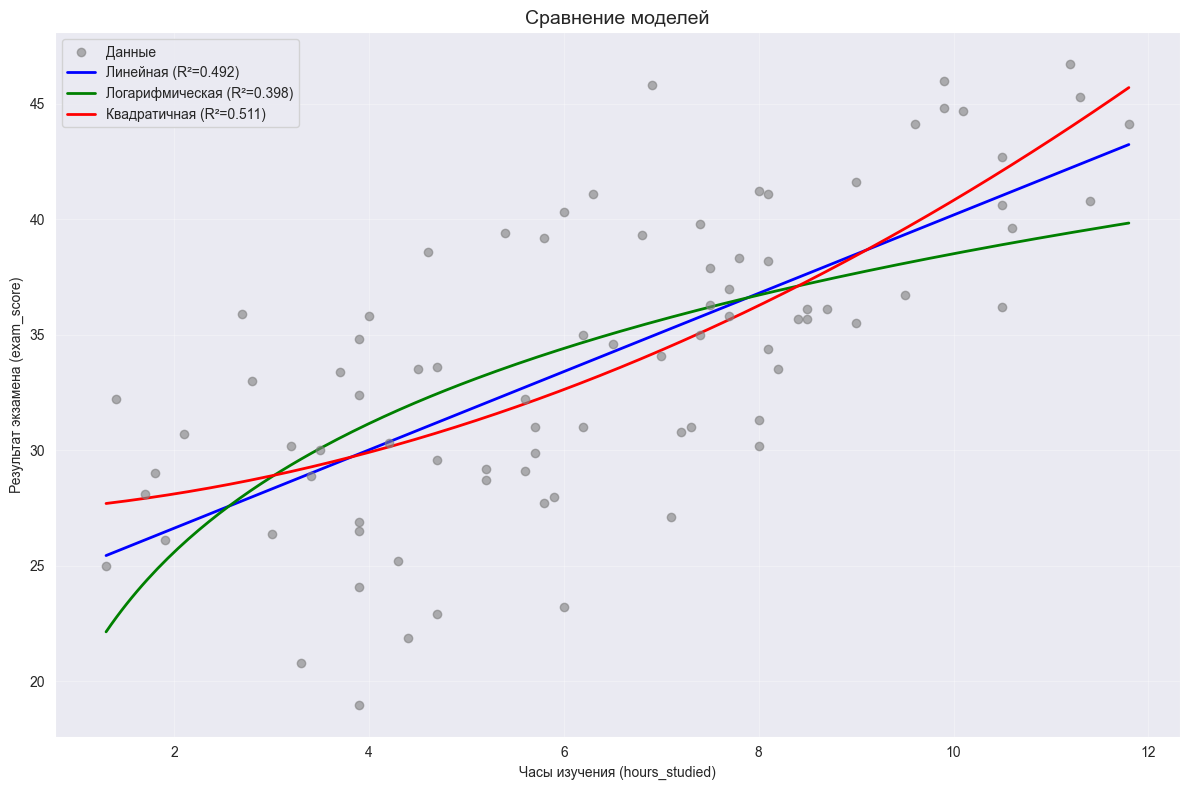

In [103]:
x_sort = np.linspace(x.min(), x.max(), 200)
plt.figure(figsize=(12, 8))

plt.scatter(x, y, alpha=0.6, color='gray', label='Данные', zorder=5)
plt.plot(x_sort, lin_model.predict(sm.add_constant(x_sort)),
         color='blue', linewidth=2, label=f'Линейная (R²={lin_metrics["R2"]:.3f})')
plt.plot(x_sort, log_model.predict(sm.add_constant(np.log(x_sort))),
         color='green', linewidth=2, label=f'Логарифмическая (R²={log_metrics["R2"]:.3f})')
X_quad_sort = sm.add_constant(pd.DataFrame({'const':1, 'x': x_sort, 'x2': x_sort**2}))
plt.plot(x_sort, quad_model.predict(X_quad_sort),
         color='red', linewidth=2, label=f'Квадратичная (R²={quad_metrics["R2"]:.3f})')

plt.title('Сравнение моделей', fontsize=14)
plt.xlabel('Часы изучения (hours_studied)')
plt.ylabel('Результат экзамена (exam_score)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [104]:
comparison = pd.DataFrame({
    'Модель': ['Линейная', 'Логарифмическая', 'Квадратичная'],
    'R²': [lin_metrics['R2'], log_metrics['R2'], quad_metrics['R2']],
    'R²_adj': [lin_metrics['R2_adj'], log_metrics['R2_adj'], quad_metrics['R2_adj']],
    'MAPE (%)': [lin_metrics['MAPE'], log_metrics['MAPE'], quad_metrics['MAPE']],
})

comparison = comparison.round(4)
comparison = comparison.sort_values(by='R²_adj', ascending=False)
print("Сравнение моделей:")
display(comparison)

Сравнение моделей:


,Модель,R²,R²_adj,MAPE (%)
2,Квадратичная,0.5108,0.4987,11.4235
0,Линейная,0.4922,0.4860,11.7858
1,Логарифмическая,0.3977,0.3904,13.0556


In [105]:
lin_model.params

const            23.245379
hours_studied     1.693656
dtype: float64

In [107]:
quad_model.params

const    27.230042
x         0.212497
x2        0.114601
dtype: float64

### j-тест Стьюдента

$H_0$ модель можно заменить линейной

$H_1$ модель нельзя заменить линейной

$t=\dfrac{R^2-r^2}{2\sqrt{\dfrac{(R^2-r^2)-(R^2-r^2)^2(2-R^2-r^2)}{n}}}$

$t_c(\alpha, n-2)$

Если $|t| < |t_c|$, то $H_0$ не отвергается

In [113]:
def j_test(det_2: float) -> bool:
    r_2 = r ** 2
    return (det_2 - r_2) / (2 * np.sqrt(((det_2 - r_2) - (det_2 - r_2) ** 2 * (2 - (det_2 + r_2))) / len(x))) < abs(stats.t.ppf(p_value, len(x) - 2))

if j_test(log_model.rsquared):
    print("Логарифмическую модель можно заменить линейной")
else:
    print("Логарифмическую модель нельзя заменить линейной")

if j_test(quad_model.rsquared):
    print("Квадратичную модель можно заменить линейной")
else:
    print("Квадратичную модель нельзя заменить линейной")

Логарифмическую модель нельзя заменить линейной
Квадратичную модель можно заменить линейной


## 7. Выводы

В результате исследования можно сделать вывод о том, что результат экзамена является линейной функцией от количества часов подготовки

**Полученное линейное уравнение:**

`y = 23.25 + 1.69 * x`

Гипотеза подтверждена